In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# Define the paths to your data folders
train_dir = 'D:\ML projects\Plant Disease Classification\Train'
val_dir = 'D:\ML projects\Plant Disease Classification\Validation'

<>:2: SyntaxWarning: invalid escape sequence '\M'
<>:3: SyntaxWarning: invalid escape sequence '\M'
<>:2: SyntaxWarning: invalid escape sequence '\M'
<>:3: SyntaxWarning: invalid escape sequence '\M'
C:\Users\samee\AppData\Local\Temp\ipykernel_19920\263128453.py:2: SyntaxWarning: invalid escape sequence '\M'
  train_dir = 'D:\ML projects\Plant Disease Classification\Train'
C:\Users\samee\AppData\Local\Temp\ipykernel_19920\263128453.py:3: SyntaxWarning: invalid escape sequence '\M'
  val_dir = 'D:\ML projects\Plant Disease Classification\Validation'


In [4]:
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
train_dataset = datasets.ImageFolder(train_dir, transform=image_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=image_transforms)

In [6]:
len(train_dataset), len(val_dataset)

(15448, 3171)

In [23]:
class_names = train_dataset.classes
print(class_names) 

['American Bollworm on Cotton', 'Anthracnose on Cotton', 'Army worm', 'Becterial Blight in Rice', 'Brownspot', 'Common_Rust', 'Cotton Aphid', 'Flag Smut', 'Gray_Leaf_Spot', 'Healthy Maize', 'Healthy Wheat', 'Healthy cotton', 'Leaf Curl', 'Leaf smut', 'Mosaic sugarcane', 'RedRot sugarcane', 'RedRust sugarcane', 'Rice Blast', 'Sugarcane Healthy', 'Tungro', 'Wheat Brown leaf Rust', 'Wheat Stem fly', 'Wheat aphid', 'Wheat black rust', 'Wheat leaf blight', 'Wheat mite', 'Wheat powdery mildew', 'Wheat scab', 'Wheat___Yellow_Rust', 'Wilt', 'Yellow Rust Sugarcane', 'bacterial_blight in Cotton', 'bollrot on Cotton', 'bollworm on Cotton', 'cotton mealy bug', 'cotton whitefly', 'maize ear rot', 'maize fall armyworm', 'maize stem borer', 'pink bollworm in cotton', 'red cotton bug', 'thirps on  cotton']


In [8]:
num_classes = len(train_dataset.classes)
num_classes

42

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [10]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [11]:
labels[1]

tensor(4)

In [12]:
images[1].shape

torch.Size([3, 224, 224])

In [13]:
images[1].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5414377..1.5051372].


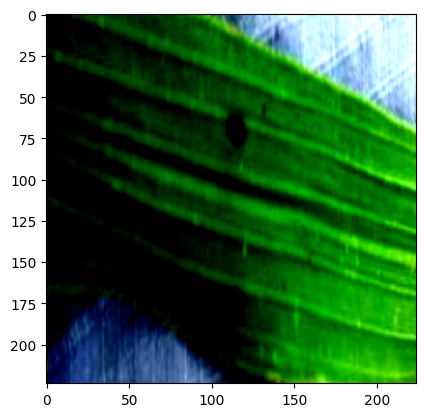

In [14]:
plt.imshow(images[1].permute(1,2,0))
plt.show()

In [15]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 50 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

In [17]:
class DiseaseClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3, inplace =True),
            nn.Linear(in_features, num_classes, bias=True)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x              

In [19]:
model = DiseaseClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=5)

Batch: 50, Epoch: 1, Loss: 1.89
Batch: 100, Epoch: 1, Loss: 1.23
Batch: 150, Epoch: 1, Loss: 1.40
Batch: 200, Epoch: 1, Loss: 1.12


C:\Users\samee\AppData\Roaming\Python\Python313\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Batch: 250, Epoch: 1, Loss: 1.04
Batch: 300, Epoch: 1, Loss: 1.05
Batch: 350, Epoch: 1, Loss: 0.85
Batch: 400, Epoch: 1, Loss: 0.80
Batch: 450, Epoch: 1, Loss: 0.45
Epoch [1/5], Avg Loss: 1.1591


C:\Users\samee\AppData\Roaming\Python\Python313\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


*** Validation Accuracy: 9.62% ***
Batch: 50, Epoch: 2, Loss: 0.47
Batch: 100, Epoch: 2, Loss: 0.67
Batch: 150, Epoch: 2, Loss: 0.77
Batch: 200, Epoch: 2, Loss: 0.86
Batch: 250, Epoch: 2, Loss: 0.43
Batch: 300, Epoch: 2, Loss: 0.26
Batch: 350, Epoch: 2, Loss: 0.39
Batch: 400, Epoch: 2, Loss: 0.49
Batch: 450, Epoch: 2, Loss: 0.44
Epoch [2/5], Avg Loss: 0.5726
*** Validation Accuracy: 15.20% ***
Batch: 50, Epoch: 3, Loss: 0.32
Batch: 100, Epoch: 3, Loss: 0.25
Batch: 150, Epoch: 3, Loss: 0.40
Batch: 200, Epoch: 3, Loss: 0.22
Batch: 250, Epoch: 3, Loss: 0.42
Batch: 300, Epoch: 3, Loss: 0.25
Batch: 350, Epoch: 3, Loss: 0.41
Batch: 400, Epoch: 3, Loss: 0.51
Batch: 450, Epoch: 3, Loss: 0.84
Epoch [3/5], Avg Loss: 0.4718
*** Validation Accuracy: 17.16% ***
Batch: 50, Epoch: 4, Loss: 0.30
Batch: 100, Epoch: 4, Loss: 0.39
Batch: 150, Epoch: 4, Loss: 0.30
Batch: 200, Epoch: 4, Loss: 0.29
Batch: 250, Epoch: 4, Loss: 0.37
Batch: 300, Epoch: 4, Loss: 0.30
Batch: 350, Epoch: 4, Loss: 0.36
Batch: 400,

In [20]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.47      0.67      0.55        30
           1       0.67      0.40      0.50        10
           2       0.98      0.69      0.81       351
           3       0.23      0.02      0.04       284
           4       0.00      0.00      0.00        22
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00        18
           7       0.00      0.00      0.00       287
           8       0.00      0.00      0.00        24
           9       0.00      0.05      0.01        20
          10       0.07      0.01      0.02       275
          11       0.00      0.00      0.00        33
          12       0.04      0.03      0.04       176
          13       0.00      0.00      0.00        81
          14       0.00      0.00      0.00        16
          15       0.01      0.02      0.01        66
          16       0.00      0.00      0.00       153
          17       0.00    

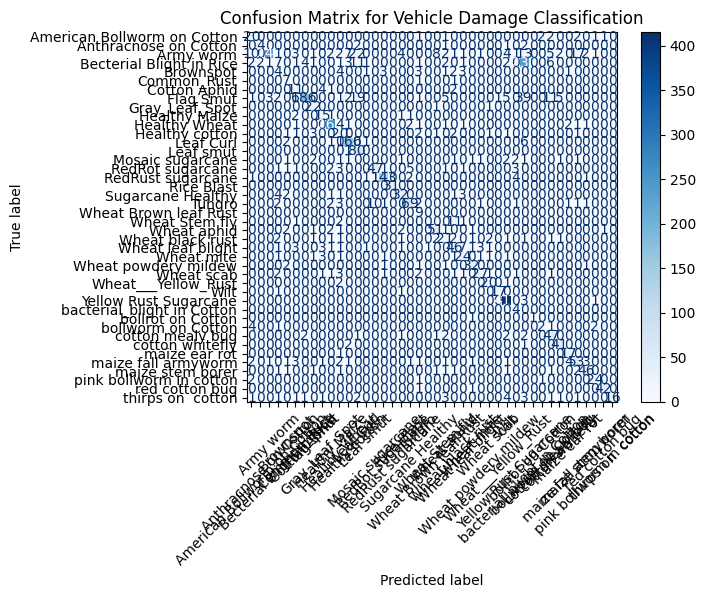

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

In [22]:
torch.save(model.state_dict(), 'saved_model.pth')